### Helper Functions


In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# plots an array of images into an image matrix
def plot_image_array(images, titles = [], ncols = 2, nrows = -1, fig_width = 20, fig_row_height = 4.5):
    if nrows <= 0:
        nrows = math.ceil(len(images) / 2)
    fig = plt.figure(figsize=(fig_width, nrows * fig_row_height))
    for idx, img in enumerate(images):
        if idx >= (nrows * ncols):
            break
        a=fig.add_subplot(nrows, ncols, idx + 1)
        if len(img.shape) == 2:
            imgplot = plt.imshow(img, cmap = 'gray' if len(img.shape) == 2 else None)
        else:
            imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     
        if(len(titles) >= idx):
            a.set_title(titles[idx])
            
# saves an array of images to a folder         
def save_images(folder, images, names):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for img, fname in zip(images, names):
        fname = fname.replace('/', '_')
        fname = fname.replace(' ', '_')
        fname = fname.replace(':', '_')
        fname = fname.replace('.jpg', '')
        p = os.path.join(folder, os.path.split(fname)[-1])

        p += '.jpg'
        if np.max(img) == 1:
            img = img * 255
        #print('saving', p)
        cv2.imwrite(p, img)

## Detect Chessboard Corners

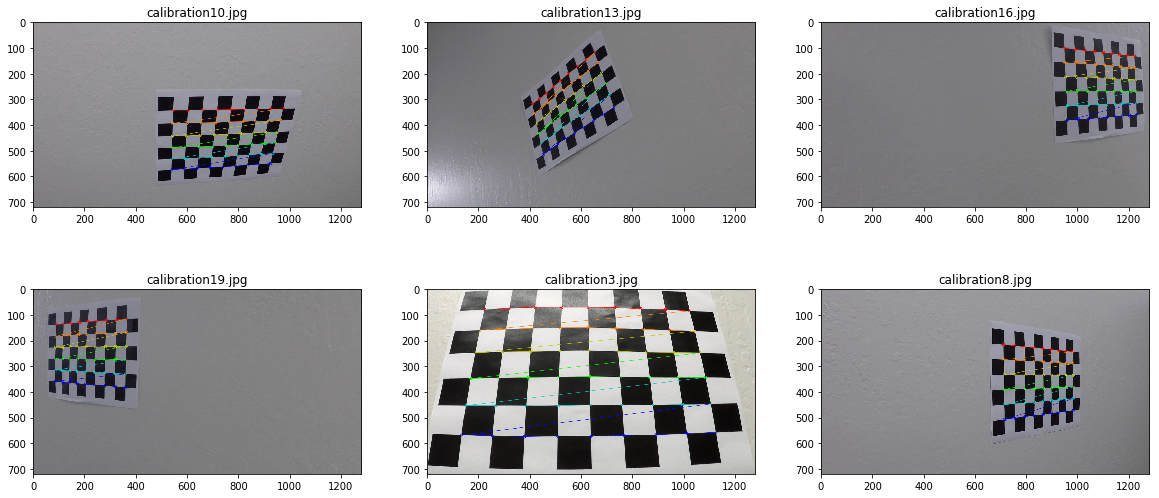

In [5]:
import os.path
import cv2
import glob

# chessboard matrix setup
n_corners = (9, 6)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((n_corners[0]*n_corners[1],3), np.float32)
objp[:,:2] = np.mgrid[0:n_corners[0], 0:n_corners[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
image_files = glob.glob('camera_cal/calibration*.jpg')

chessboardImages = []
chessboardNames = []
chessboardCornerNames = []
chessboardCornerImages = []
# Step through the list and search for chessboard corners
for idx, fname in enumerate(image_files):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    chessboardImages.append(img)
    chessboardNames.append(os.path.split(fname)[-1])

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, n_corners, None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cornerImg = img.copy()
        cv2.drawChessboardCorners(cornerImg, n_corners, corners, ret)
        chessboardCornerImages.append(cornerImg)
        chessboardCornerNames.append(os.path.split(fname)[-1])
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)

plot_image_array(chessboardCornerImages[::3], chessboardCornerNames[::3], ncols=3, nrows=2)
#save_images('images', chessboardCornerImages[::3], chessboardCornerNames[::3])

## Camera Calibration
- caluclate camera calibration from detected chessboard cordners
- undistort and project all chessboards into image plane
- save camera calibration

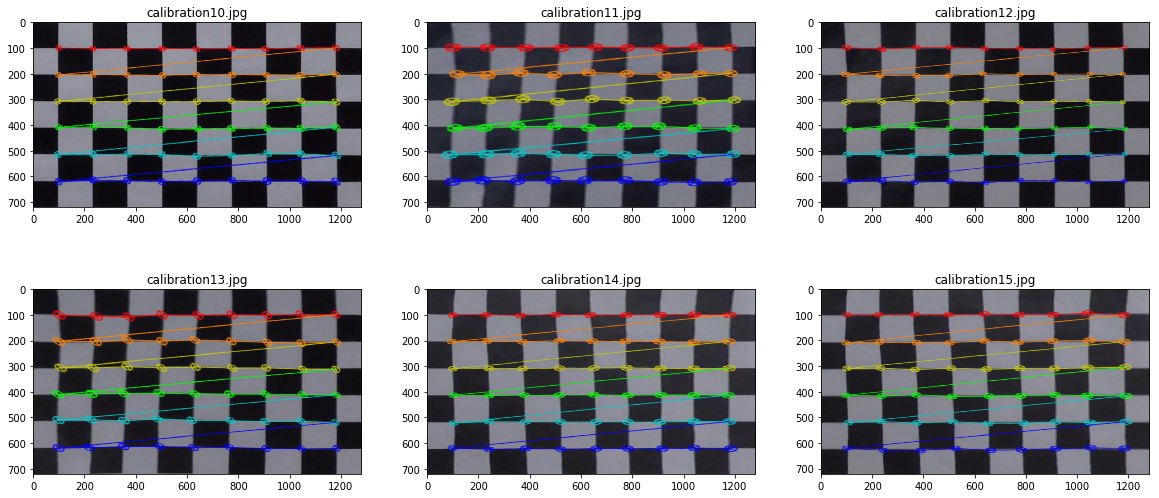

In [6]:
import pickle

img_size = (chessboardImages[0].shape[1], chessboardImages[0].shape[0])
# Do camera calibration given object points and image points
#print(objpoints)
#print(imgpoints)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

# Make a list of calibration images
# Step through the list and search for chessboard corners
undistortedImages = []
undistortedNames = []
for idx, img in enumerate(chessboardImages):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    #undistortedImages.append(gray)
    #undistortedNames.append(chessboardNames[idx])
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, n_corners, None)
    
    # If corners found: 
    if ret:
        # a) draw corners
        cv2.drawChessboardCorners(undist, n_corners, corners, ret)
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        offset = 100
        img_size = (undist.shape[1], undist.shape[0])
        src = np.float32([corners[0], corners[n_corners[0]-1], corners[-1], corners[-n_corners[0]]])

        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])


        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        undistortedImages.append(warped)
        undistortedNames.append(chessboardNames[idx])
        
plot_image_array(undistortedImages, undistortedNames, ncols=3, nrows=2)
#save_images('images', undistortedImages, undistortedNames)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
cam_calibration = {}
cam_calibration["mtx"] = mtx
cam_calibration["dist"] = dist
pickle.dump( cam_calibration, open( "camera_calibration.p", 'wb'))

## Load Camera Calibration

In [7]:
import os
import os.path

cam_calibration = pickle.load( open( "camera_calibration.p", "rb" ) )
print('Loaded camera calibration')
print('--------------------------')
print('mtx:\n', cam_calibration['mtx'])
print('\ndist:\n', cam_calibration['dist'])
    
def undistort_image(img):
    return cv2.undistort(img, cam_calibration['mtx'], cam_calibration['dist'], None, cam_calibration['mtx'])

Loaded camera calibration
--------------------------
mtx:
 [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

dist:
 [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


## Thresholding Functions
Thresholding functions to be used in image preprocessing steps for lane detection. 

In [8]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds any number of channels with individual thresholds
# and combines the results using AND
def combined_channel_threshold(img, channels=[0, 1, 2], thresh=[(0, 255), (0, 255), (0, 255)], color_conversion = cv2.COLOR_BGR2HLS):
    if color_conversion:
        c = cv2.cvtColor(img, color_conversion)
    else:
        c = img       
    b = []
    for channel, t in zip(channels, thresh):
        s = c[:,:,channel]
        binary_output = np.zeros(s.shape, dtype=np.uint8)
        binary_output[(s >= t[0]) & (s <= t[1])] = 1
        b.append(binary_output)
    
    return np.minimum.reduce(np.dstack(tuple(b)), axis=2)


## Load Test Images

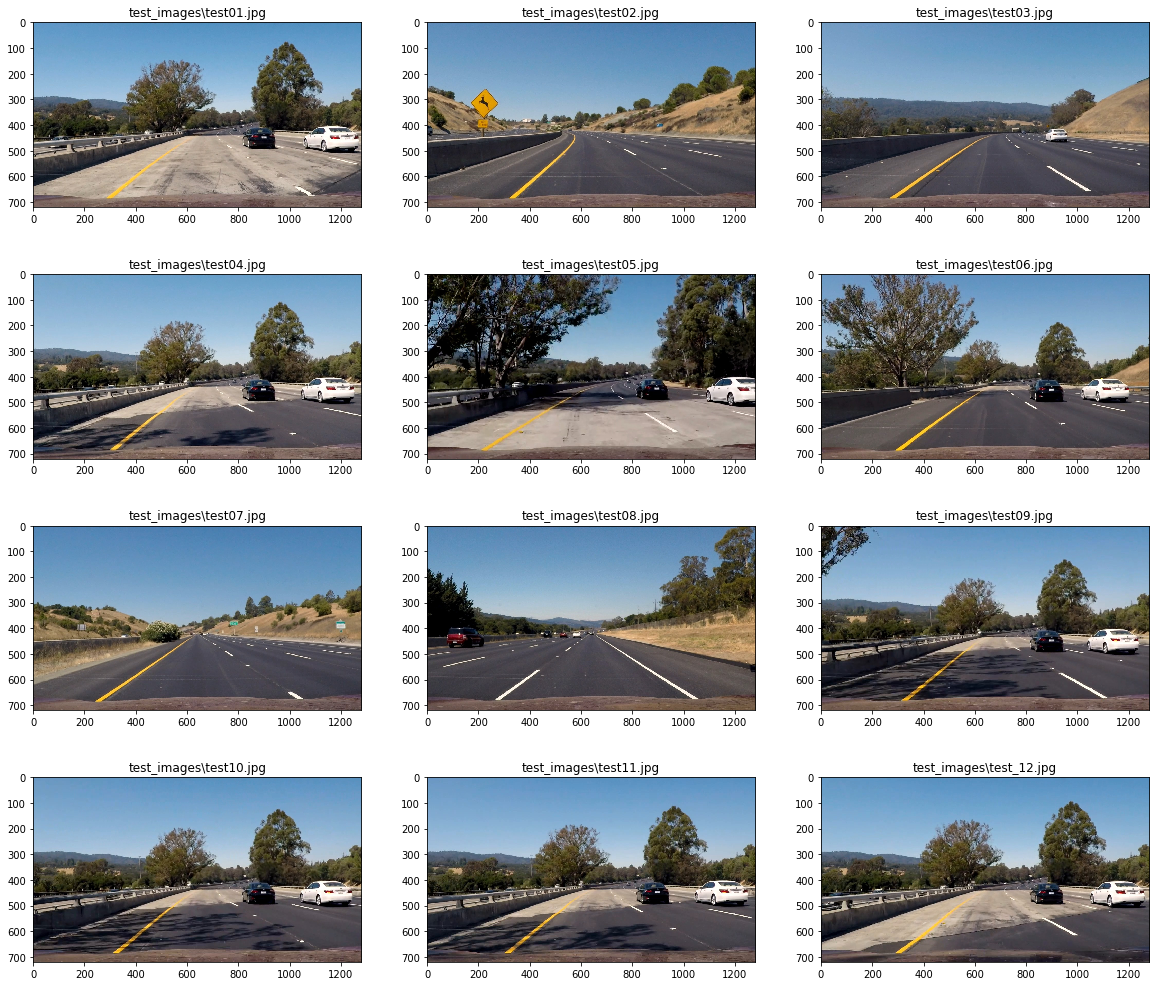

In [9]:

image_files = glob.glob('test_images/test*.jpg')

test = []
test_n = []
for idx, fname in enumerate(image_files):
    test.append(cv2.imread(fname))
    test_n.append(fname)
    
plot_image_array(test, test_n, ncols=3)   

## Perspective Transform
Calculate transformation matrix to warp undistorted camera images into a bird view that lets us estimate lane curvature.

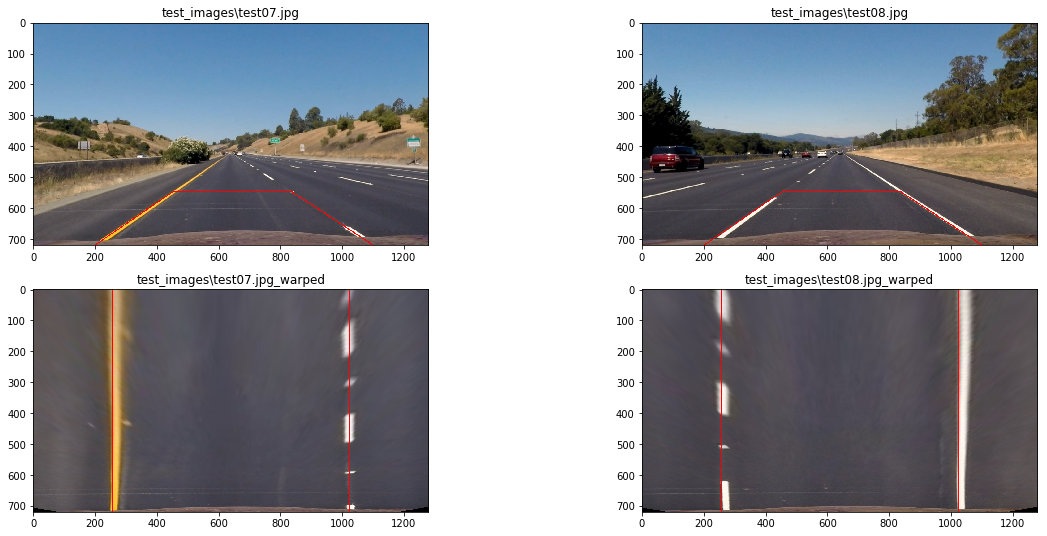

In [10]:
straight_image = test[6]
img_size = (straight_image.shape[1], straight_image.shape[0])

# these image points have been determined manually and seem to work fine
w,h = 1280,720
x,y = 0.6*w, 0.8*h
warp_src = np.float32([[200./1280*w,720./720*h],
              [453./1280*w,547./720*h],
              [835./1280*w,547./720*h],
              [1100./1280*w,720./720*h]])
warp_dst = np.float32([[(w-x)/2.,h],
              [(w-x)/2.,0.82*h],
              [(w+x)/2.,0.82*h],
              [(w+x)/2.,h]])
warp_line = np.float32([[(w-x)/2.,h],
              [(w-x)/2.,0],
              [(w+x)/2.,0],
              [(w+x)/2.,h]])

# transformation matrix from camera into bir view and its inverse
M_perspective = cv2.getPerspectiveTransform(warp_src.astype(np.float32), warp_dst.astype(np.float32))
Minv_perspective = cv2.getPerspectiveTransform(warp_dst.astype(np.float32), warp_src.astype(np.float32))

def draw_lines(src, lines, color = [0, 0, 255], thickness = 2, skip = False):
    img = src
    if len(img.shape) == 2:
        if np.max(src) <= 1:
            img = np.uint8(img.reshape((img.shape[0], img.shape[1], 1)) * 255)
            img = np.repeat(img, 3, axis=2)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    s = 2 if skip else 1
    for p in range(0, len(lines) - 1, s):
        cv2.line(img, tuple(lines[p].astype(int)), tuple(lines[p+1].astype(int)), color, thickness)
    return img
        
# convenience function to warp an image from cam to bird
def warp_to_image_plane(img, M = M_perspective):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
out = []
out_n = []
for i in range(6, 8):
    c = draw_lines(undistort_image(test[i]), warp_src)
    out.append(c)
    out_n.append(test_n[i])

# for convenience the straight line images have been renamed to test7.jpg and test8.jpg locally
# to load them with the others in a glob
for i in range(6, 8):
    warped = warp_to_image_plane(undistort_image(test[i]), M_perspective)
    cv2.imwrite("output_images/warped_{}.jpg".format(i), warped);
    warped = draw_lines(warped, warp_line, skip = True)
    out.append(warped)
    out_n.append(test_n[i] + '_warped')
    
plot_image_array(out, out_n, ncols=2)
#save_images('images', out, out_n)

## Image Preprocessing
The preprocessing cuntion takes a camera image and returns a binary image in bird view that shows pixels that could categorize as lane pixels. It uses the following steps:
- undistort image
- warp image into birdview
- apply a color threshold to detect white and yellow lines
- apply a gradient threshold in x-direction to detect vertical lines
- combine both thresholds using OR

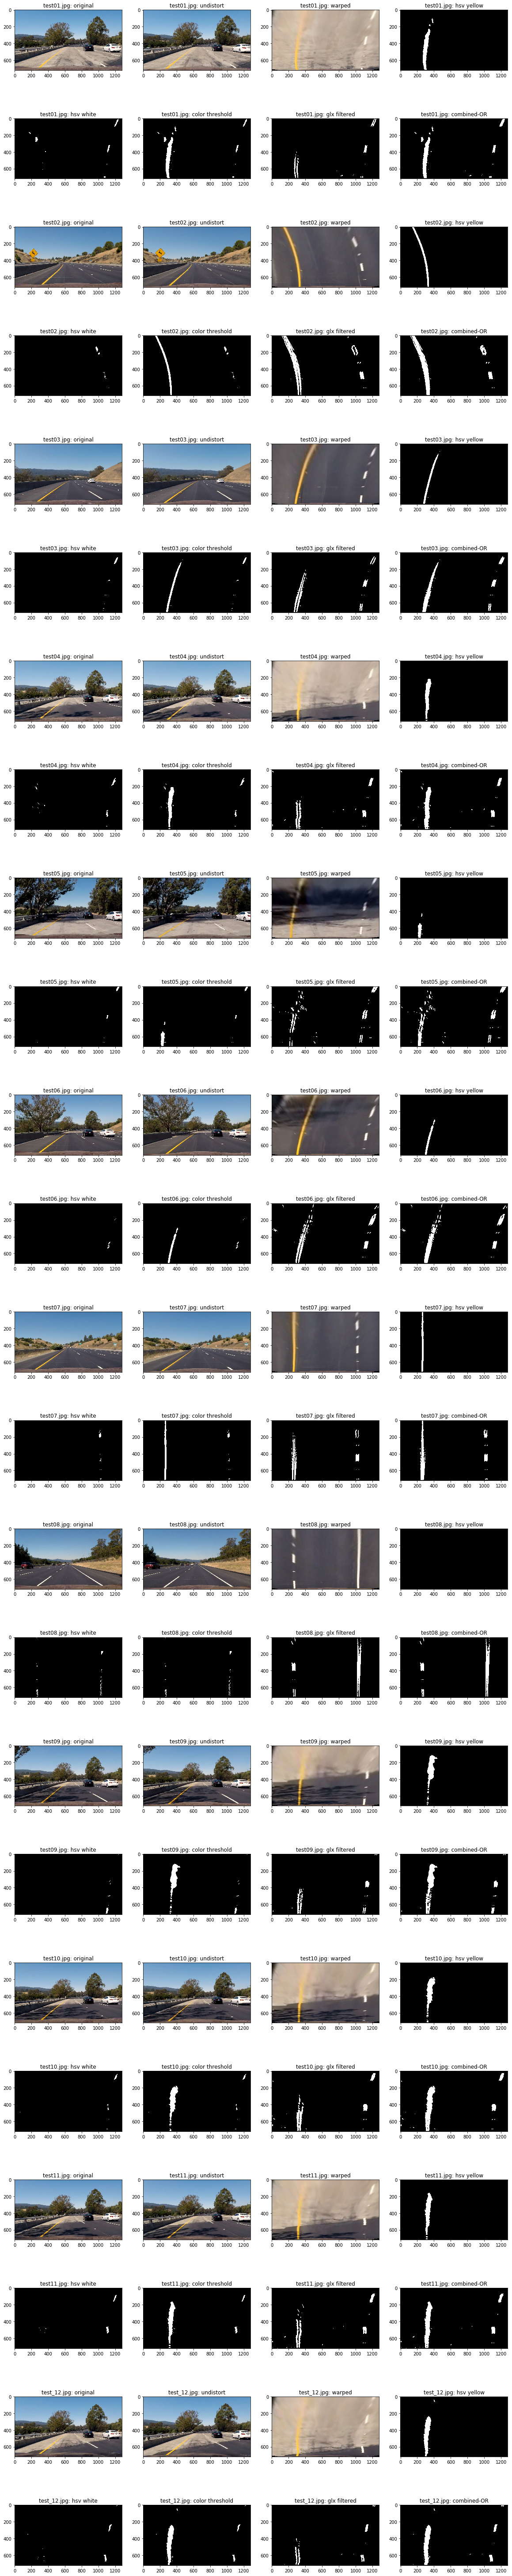

In [12]:


def preprocess_image(img, img_name = ''):
    out = []
    out_n = []
    
    img_prefix = img_name + ': '
    out.append(img)
    out_n.append(img_prefix + 'original')
    
    #undistort image
    undistort = undistort_image(img)
    out.append(undistort)
    out_n.append(img_prefix + 'undistort')
    
    # warp image
    warped = warp_to_image_plane(undistort)
    out.append(warped)
    out_n.append(img_prefix + 'warped')
    
    # apply color thresholds
    binary_hsv_yellow = combined_channel_threshold(warped, channels=[0, 1, 2], thresh=[(0, 40), (80, 255), (200, 255)], color_conversion = cv2.COLOR_BGR2HSV)   
    binary_hsv_white = combined_channel_threshold(warped, channels=[0, 1, 2], thresh=[(20, 255), (0, 80), (200, 255)], color_conversion = cv2.COLOR_BGR2HSV)
    out.append(binary_hsv_yellow)
    out_n.append(img_prefix + 'hsv yellow')
    out.append(binary_hsv_white)
    out_n.append(img_prefix + 'hsv white')
    
    # combine color thresholds for later demonstration
    binary_color = np.zeros_like(binary_hsv_white, dtype=np.uint8)
    binary_color[(binary_hsv_yellow == 1) | (binary_hsv_white == 1)] = 1
    out.append(binary_color)
    out_n.append(img_prefix + 'color threshold')
    
    # detect vertical lines with sobel in x-direction
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    binary_gx_l = abs_sobel_thresh(hls[:,:,1], orient='x', sobel_kernel=7, thresh=(40, 255))
    binary_gx_s = abs_sobel_thresh(hls[:,:,2], orient='x', sobel_kernel=7, thresh=(25, 255))
    
    # combine gradients for later demonstration
    binary_sobel = np.zeros_like(binary_gx_l, dtype=np.uint8)
    binary_sobel[(binary_gx_l == 1) | (binary_gx_s == 1)] = 1
    binary_gx_filtered = cv2.medianBlur(binary_sobel, 9) 
    out.append(binary_gx_filtered)
    out_n.append(img_prefix + 'glx filtered')  
    
    # combine all threshold images
    binary = np.zeros_like(binary_color)
    binary[(binary_color == 1) | (binary_gx_filtered == 1)] = 1
    out.append(binary)
    out_n.append(img_prefix + 'combined-OR')
    
    return undistort, binary, out, out_n

# display test data
out = []
out_n = []
i=4
for i in range(len(test)):
    _, warped, o, o_n = preprocess_image(test[i], img_name = os.path.split(test_n[i])[-1])
    out += o
    out_n += o_n

plot_image_array(out, out_n, ncols=4) 
#save_images('output_images', out, out_n)

## Lane Detection

In [76]:
import operator
import scipy.misc

# helper function that allows to put text onto an image tat is aligned to the right, left or center
def put_text(img, text, margin_x, y, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale = 1, color = (255, 255, 255), thickness = 1, line = cv2.LINE_AA, align='left'):
    if align == 'left':
        cv2.putText(img, text, (margin_x, y), fontFace, fontScale, color, thickness, cv2.LINE_AA)
    elif align == 'right':
        textsize,_ = cv2.getTextSize(text, fontFace, fontScale, thickness)
        cv2.putText(img, text, (img.shape[1] - margin_x - textsize[0], y), fontFace, fontScale, color, thickness, line)
    elif align == 'center':
        textsize,_ = cv2.getTextSize(text, fontFace, fontScale, thickness)
        cv2.putText(img, text, ((img.shape[1] - textsize[0]) // 2 + margin_x, y), fontFace, fontScale, color, thickness, line)


# helper class to be used when no previous curve is available and
# we use a sliding window starting from the bottom at the local histogram peaks
# and then gradually slide up the lane
class SlidingWindow:

    def __init__(self, start_pos_x, image_height, n_windows = 9, window_margin = 100):
        self.window_height = np.int(image_height / n_windows)
        self.margin = window_margin
        self.image_height = image_height
        pos = []
        for p in start_pos_x:
            pos.append([(-1, p)])
        self.pos_x = tuple(pos)
        
    # sets the current position of a window at given index    
    def set_window_x(self, level, window_index, window_pos_x):
        self.pos_x[window_index].append((level, window_pos_x))
    
    # returns top and bottom of a window at a given level
    def get_window_y(self, level):
        y_high = self.image_height - level * self.window_height
        y_low = y_high - self.window_height
        return y_low, y_high
    
    # returns left and right of a window at a given level using
    # the predefined window magin and the previous
    # window positions for prediction (linear extrapolation)
    def get_window_x(self, level, window_index):
        cur_lvl, cur_x = self.pos_x[window_index][-1]
        if cur_lvl > 0:
            diff = tuple(map(operator.sub, (cur_lvl, cur_x), self.pos_x[window_index][-2]))
            offset = (level - cur_lvl) * diff[1] / diff[0]
            cur_x += np.int(0.5 * offset)
        return cur_x - self.margin, cur_x + self.margin
            
# helper class to track a single line
# it allows averaging over the last n states to make results appear smoother
class Line:
    def __init__(self, size=10):
        self.poly = []
        self.id = []
        self.pixel = []
        self.size = size
        self.curverad = []
        
    # returns the current or the average curve    
    def get_poly(self, mode='current'):
        if len(self.poly) > 0:      
            if mode == 'current':
                return self.poly[0], self.id[0]
            elif mode == 'mean':
                return np.mean(np.array(self.poly), axis=0), self.id[0]
        return np.array([]), -1
    
    # returns the current or the average number of hot pixels
    # used to detect that line
    def get_pixel_count(self, mode='current'):
        if len(self.pixel) > 0:      
            if mode == 'current':
                return self.pixel[0]
            elif mode == 'mean':
                return np.mean(np.array(self.poly))
        return 0
    
    # returns the current or the average curve radius
    def get_curve_radius(self, mode='current'):
        if len(self.curverad) > 0:      
            if mode == 'current':
                return self.curverad[0]
            elif mode == 'mean':
                return np.mean(np.array(self.curverad), axis=0)
        return 0
    
    # add a new 'current' curve to the list
    # remove the oldest one if size is exceeded
    def add_poly(self, p, p_id, curverad):
        self.poly = [p[0]] + self.poly[:self.size - 1]
        self.pixel = [p[1]] + self.pixel[:self.size - 1]
        self.id = [p_id] + self.id[:self.size - 1]
        self.curverad = [curverad] + self.curverad[:self.size - 1]
        
    # returns true of no curve is there
    def empty(self):
        return len(self.poly) == 0
        
# helper class that combines two lines to a lane and allows
class Lane:
    def __init__(self, img_shape, hist_size = 10, y_scale = 30/720, x_scale = 3.7/760):
        self.frame_counter = 0
        self.hist_size = hist_size
        self.img_shape = img_shape
        self.y_scale = y_scale
        self.x_scale = x_scale
        self.lines = (Line(size = hist_size), Line(size = hist_size))
    
    # returns averaged or current curve radius
    def get_curve_radius(self, line_index= -1, mode='mean'):
        if line_index < 0:
            left = self.lines[0].get_curve_radius(mode)
            right = self.lines[1].get_curve_radius(mode)
            return (left + right) * 0.5
        else:
            return self.lines[line_index].get_curve_radius(mode)
    
    # returns offset from the middle of the camera
    def get_center_offset(self, mode='mean'):
        left_fit = self.lines[0].get_poly(mode)[0]
        right_fit = self.lines[1].get_poly(mode)[0]
        
        if len(left_fit) < 1 or len(right_fit) < 1:
            return 0
        
        y_eval = self.img_shape[0]
        leftx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        rightx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        
        img_center = self.img_shape[1] * 0.5
        cur_center = (leftx + rightx) * 0.5
        return (cur_center - img_center) * self.x_scale
    
    # returns number of hot pixels
    def get_pixel_count(self, line_index = -1, mode='mean'):
        if line_index < 0:
            left = self.lines[0].get_pixel_count(mode)
            right = self.lines[1].get_pixel_count(mode)
            return (left + right) * 0.5
        else:
            return self.lines[line_index].get_pixel_count(mode)
        
    # returns curve
    def get_poly(self, line_index, mode='current'):
        return self.lines[line_index].get_poly(mode)
    
    # set the current curve
    # returns true of the line pair was acceptable as a lane
    def set_poly(self, left, right):
        curverad = [self.calculate_curveradius(left[2]),
                    self.calculate_curveradius(right[2])]
        
        # debugging information
        self.delta_cr = [0, 0]
        self.delta_poly = [np.zeros(3), np.zeros(3)]
        p = [left, right]
        
        for i in range(2):
            if not self.lines[i].empty():
                self.delta_cr[i] = curverad[i] - self.get_curve_radius(i, mode='mean')
                poly = self.get_poly(i, mode='mean')[0]
                self.delta_poly[i] = ((p[i][0] - poly) / poly  * 100)
                
        y_eval = self.img_shape[0]
        leftx = left[0][0]*y_eval**2 + left[0][1]*y_eval + left[0][2]
        rightx = right[0][0]*y_eval**2 + right[0][1]*y_eval + right[0][2]
        self.line_dist = (rightx - leftx) * self.x_scale
        
        # update both lines with their new curves if the ine distance
        # at the car's position does not deviate more than 0.3 m
        result = False
        if abs(self.line_dist - 3.75) < 0.3:
            self.lines[0].add_poly(left, self.frame_counter, curverad[0])
            self.lines[1].add_poly(right, self.frame_counter, curverad[1])
            result = True
        self.frame_counter += 1
        return result
    
    # calculates the curveradius at the car's position
    # using the givvn image scaling (pixel to meters by default)
    def calculate_curveradius(self, x_vals):
        ploty = np.linspace(0, self.img_shape[0]-1, self.img_shape[0])
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(ploty*self.y_scale, x_vals*self.x_scale, 2)
        
        # Calculate the new radii of curvature
        y_eval = np.max(ploty)
        curverad = ((1 + (2*fit_cr[0]*y_eval*self.y_scale + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curverad
    
# takes a binary image in bird view and detects the lane
# the current lane detection will be used to guide the search
def detect_lanes(binary_warped, lane, debug = False):
    left_fit, left_id = lane.get_poly(0)
    right_fit, right_id = lane.get_poly(1)

    if debug:
        debug_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 
        
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []    
    
    # if no previous lane detection is available we use sliding window
    # approach for this frame
    if left_id < 0 or right_id < 0:
        histogram = np.sum(warped[binary_warped.shape[0]//2:,:], axis=0)
                  
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint   
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        n_windows = 9
        window = SlidingWindow(start_pos_x=[leftx_base, rightx_base], 
                               image_height=binary_warped.shape[0], 
                               n_windows=n_windows, 
                               window_margin=margin)   

        # Step through the windows one by one
        for level in range(n_windows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low, win_y_high = window.get_window_y(level)
            win_xleft_low, win_xleft_high = window.get_window_x(level, 0)
            win_xright_low, win_xright_high = window.get_window_x(level, 1)

            # Draw the windows on the visualization image
            if debug:
                cv2.rectangle(debug_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
                cv2.rectangle(debug_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                window.set_window_x(level, 0, np.int(np.mean(nonzerox[good_left_inds])))
            if len(good_right_inds) > minpix:        
                window.set_window_x(level, 1, np.int(np.mean(nonzerox[good_right_inds])))


        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    else:
        # we have a current lane fitting we use its boundary to search for lanes
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
    # Fit a second order polynomial to each
    next_left_fit = np.polyfit(nonzeroy[left_lane_inds], nonzerox[left_lane_inds], 2)
    next_right_fit = np.polyfit(nonzeroy[right_lane_inds], nonzerox[right_lane_inds], 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    next_left_fitx = next_left_fit[0]*ploty**2 + next_left_fit[1]*ploty + next_left_fit[2]
    next_right_fitx = next_right_fit[0]*ploty**2 + next_right_fit[1]*ploty + next_right_fit[2]
    ok = lane.set_poly((next_left_fit, len(left_lane_inds.nonzero()[0]), next_left_fitx), (next_right_fit, len(right_lane_inds.nonzero()[0]), next_right_fitx))

    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([next_left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([next_right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    if debug:
        # color pixels that contributed to lanes in debug image
        debug_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        debug_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # Draw the lane onto the warped blank image
        cv2.polylines(debug_img, np.int_([pts_left]), False, (0,255, 255), 3, cv2.LINE_AA)
        cv2.polylines(debug_img, np.int_([pts_right]), False, (0,255, 255), 3, cv2.LINE_AA)
 
        if left_id >= 0 and right_id >= 0:
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([next_left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([next_left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([next_right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([next_right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            window_img = np.zeros_like(debug_img)
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            debug_img = cv2.addWeighted(debug_img, 1, window_img, 0.3, 0)
            
            
    # for the actual lane detection we are using an average over the last reported lanes
    avg_left_fit = lane.get_poly(line_index=0, mode='mean')[0]
    avg_right_fit = lane.get_poly(line_index=1, mode='mean')[0]
        
    avg_left_fitx = avg_left_fit[0]*ploty**2 + avg_left_fit[1]*ploty + avg_left_fit[2]
    avg_right_fitx = avg_right_fit[0]*ploty**2 + avg_right_fit[1]*ploty + avg_right_fit[2]
     
    pts_left = np.array([np.transpose(np.vstack([avg_left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([avg_right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # draw lanes in blank image that will be warped  back later and overlayed onto the original image
    lane_img = np.zeros(binary_warped.shape + (3,), dtype=np.uint8)
    polycol = (0, 255, 0) if ok else (0, 0, 255)
    cv2.fillPoly(lane_img, np.int_([pts]), polycol)
    
    result =[lane_img]
    if debug:
        result += [debug_img]
    return result
       
# processing function for videos and test images that will process
# an image with the full detection pileline
# fir videos the img_type will be rgb. images loaded by opencv will be bgr
class LaneDetector:
    def __init__(self, img_type='bgr', img_shape=(720, 1280), debug = False):
        self.lane = Lane(img_shape=img_shape)
        self.debug = debug
        self.img_type = img_type
        
    def process_image(self, img):
        if self.img_type == 'rgb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
        # pipelie consisting of 
        #  - preprocessing, 
        #  - lane detecting and 
        #  - warping back into camera coordinates    
        self.undist, self.binary_warped, self.prep_images, _ = preprocess_image(img)
        self.detection = detect_lanes(self.binary_warped, self.lane, debug=self.debug)        
        self.warped_detection = cv2.warpPerspective(self.detection[0], Minv_perspective, (undist.shape[1], undist.shape[0]))       
       
        # Combine the result with the original image
        # and add urvature nd offset as text to the image
        self.lane_img = cv2.addWeighted(self.undist, 1, self.warped_detection, 0.3, 0)
        curverad = self.lane.get_curve_radius(mode='mean')
        offset = self.lane.get_center_offset(mode='mean')
        cv2.putText(self.lane_img,"radius of curvature: {:.0f}m".format(curverad),(20, 50), cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA)
        cv2.putText(self.lane_img,"vehicle offset from center: {:+.2f}m".format(offset),(20, 100), cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA)
        cv2.putText(self.lane_img, "{:04d}".format(self.lane.frame_counter), (1180, 40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),1, cv2.LINE_AA)
        
        result = self.lane_img
        # if in debug mode we will embed other information into the image
        if self.debug:
            h, w, d = self.lane_img.shape
            embedded = np.zeros((h, np.int32(w * 1.5), d), dtype=np.uint8)
            embedded[0:h, 0:w, ] = self.lane_img
            debug_img = scipy.misc.imresize(self.detection[1], size=(h//2, w//2, 3))
            embedded[0:debug_img.shape[0], w:w+debug_img.shape[1], ] = debug_img
            
            text_img = np.zeros_like(debug_img)
            left_curve = self.lane.get_curve_radius(line_index=0, mode='current')
            right_curve = self.lane.get_curve_radius(line_index=1, mode='current')
            center = self.lane.get_center_offset(mode='current')
            left_pix = self.lane.get_pixel_count(line_index=0, mode='current')
            right_pix = self.lane.get_pixel_count(line_index=1, mode='current')
            dcr = self.lane.delta_cr
            dp = self.lane.delta_poly
            dl = self.lane.line_dist
            
            put_text(text_img, "{:.0f} m".format(left_curve),10, 50, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:.0f} m".format(right_curve),10, 50, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:+.2f} m".format(center),0, 50, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'center')
            put_text(text_img, "{:+.0f} m".format(dcr[0]),10, 100, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:+.0f} m".format(dcr[1]),10, 100, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:d} px".format(left_pix),10, 150, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:d} px".format(right_pix),10, 150, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:.2f} m".format(dl),0, 220, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'center')
            put_text(text_img, "{:+.2f}%".format(dp[0][0]),10, 220, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:+.2f}%".format(dp[0][1]),10, 270, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:+.2f}%".format(dp[0][2]),10, 320, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:+.2f}%".format(dp[1][0]),10, 220, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:+.2f}%".format(dp[1][1]),10, 270, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:+.2f}%".format(dp[1][2]),10, 320, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            
            embedded[h//2:h//2+text_img.shape[0], w:w+text_img.shape[1], ] = text_img
            result = embedded

        if self.img_type == 'rgb':
            result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        return result


## Test Pipeline
This cell was used to test the pieline on images scraped from the video.
For demo perposes we will use the test images.
Does not really make sense here as the test images aren't from consecutive shots.

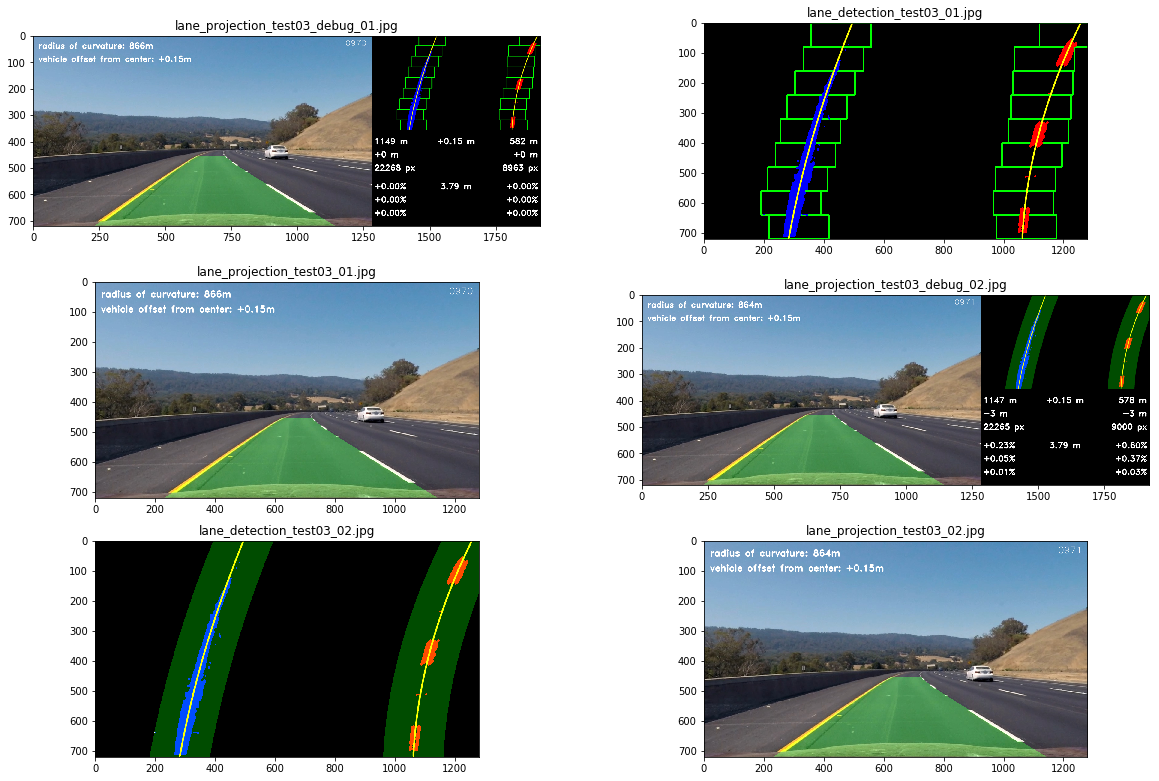

In [79]:
#image_files = glob.glob('debug_images/video_*.jpg')

#video = []
#video_n = []
#for idx, fname in enumerate(image_files):
#    video.append(cv2.imread(fname))
#    video_n.append(fname)

t = [test[2], test[2]]
tn = [test_n[2], test_n[2]]

out = []
out_n = []
lane_detector = LaneDetector(debug=True)
lane_detector.lane.frame_counter = 969
for i in range(0, len(t), ):
    img_name = os.path.split(tn[i])[-1]
    
    out.append(lane_detector.process_image(t[i]))
    out_n.append("lane_projection_{}_debug_{:02d}.jpg".format(img_name[:-4], i+1))
    
    out.append(lane_detector.detection[1])
    out_n.append("lane_detection_{}_{:02d}.jpg".format(img_name[:-4], i+1))
    
    out.append(lane_detector.lane_img)
    out_n.append("lane_projection_{}_{:02d}.jpg".format(img_name[:-4], i+1))
#save_images('images', out, out_n)    
plot_image_array(out, out_n, ncols=2) 

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`project_video.mp4`




In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
# this class allows to save and image range from a video to files for debugging
# purposes
class VideoScraper:
    def __init__(self, first_frame = 0, last_frame = -1, folder = 'debug_images'):
        self.folder = folder
        self.img_counter = 0
        self.first_frame = first_frame
        self.last_frame = last_frame

    def process_image(self, img):
        if self.img_counter >= self.first_frame and (self.img_counter <= self.last_frame or self.last_frame == -1):
            cv2.imwrite(os.path.join(self.folder, "video_{:04d}.jpg".format(self.img_counter)), cv2.cvtColor(img, cv2.COLOR_RGB2BGR));
        self.img_counter += 1

        return img


## Process Project Video

In [80]:
video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
#video_filter = VideoScraper(first_frame = 970, last_frame = 999)
video_filter = LaneDetector(img_type='rgb', debug=True)
video_clip = clip1.fl_image(video_filter.process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:09<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 6min 11s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_lane_detection))